# Reconnaissance des lettres de la langue américaine des signes

Le but de ce projet est de créer un réseau de neurones à convolution pour créer un algorithme de reconnaissance d'image permettant de reconnaitre des lettres de la langue des signes américaine.

In [20]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Load Data
train_set = pd.read_csv('../data/sign_mnist_train.csv')
train_set, val_set = train_test_split(train_set, test_size = 0.2, random_state = 42)

In [5]:
# Preprocessing
y_train = train_set['label']
y_val = val_set['label']
del train_set['label']
del val_set['label']

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.fit_transform(y_val)

x_train = train_set.values
x_val = val_set.values

x_train = x_train / 255
x_val = x_val / 255

x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)

## Création du modèle
### Travailler les images d'entrainement
On commence par créer un objet ImageDataGenerator qui va nous permettre de travailler sur les images d'entrainement. On va pouvoir faire de la data augmentation, c'est à dire modifier les images d'entrainement pour en créer de nouvelles. Cela permet d'augmenter la taille de notre dataset et donc d'améliorer les performances de notre modèle.
Cet objet crée des nouvelles images ç partir des images de base en appliquand des rotations, des zooms, des translations, etc. On peut choisir les transformations à appliquer et les paramètres de ces transformations.

In [6]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

### Model
On va également utiliser notre objet ReduceLROnPlateau pour réduire le learning rate si la validation accuracy ne s'améliore plus. Cela permet d'obtenir un modèle plus fiable.

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

On crée ensuite le modèle : 
On initilise le modèle avec la fonction Sequential() de Keras. On ajoute ensuite les couches de convolution, de pooling, de normalisation et de dropout. On termine par une couche dense de 24 neurones (nombre de classes) avec une fonction d'activation softmax.

In [8]:
# Model
model = Sequential()

model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 24 , activation = 'softmax'))

### Compilation et entrainement du modèle

In [9]:
# Compilation
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [10]:
# Summarize layers
model.summary()
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20 , validation_data = (x_val, y_val) , callbacks = [learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

## Données de test
On récupère le jeu d'images de test qu'on process de la même manière que le jeu d'entrainement.

In [11]:
# Test data : load and preprocessing
test_set = pd.read_csv('../data/sign_mnist_test.csv')
y = test_set['label']

y_test = test_set['label']
del test_set['label']

label_binarizer = LabelBinarizer()
y_test = label_binarizer.fit_transform(y_test)
x_test = test_set.values

# Normalize the data
x_test = x_test / 255

# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_test = x_test.reshape(-1,28,28,1)

In [12]:
# Accuracy
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 9ms/step - loss: 7.0777e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


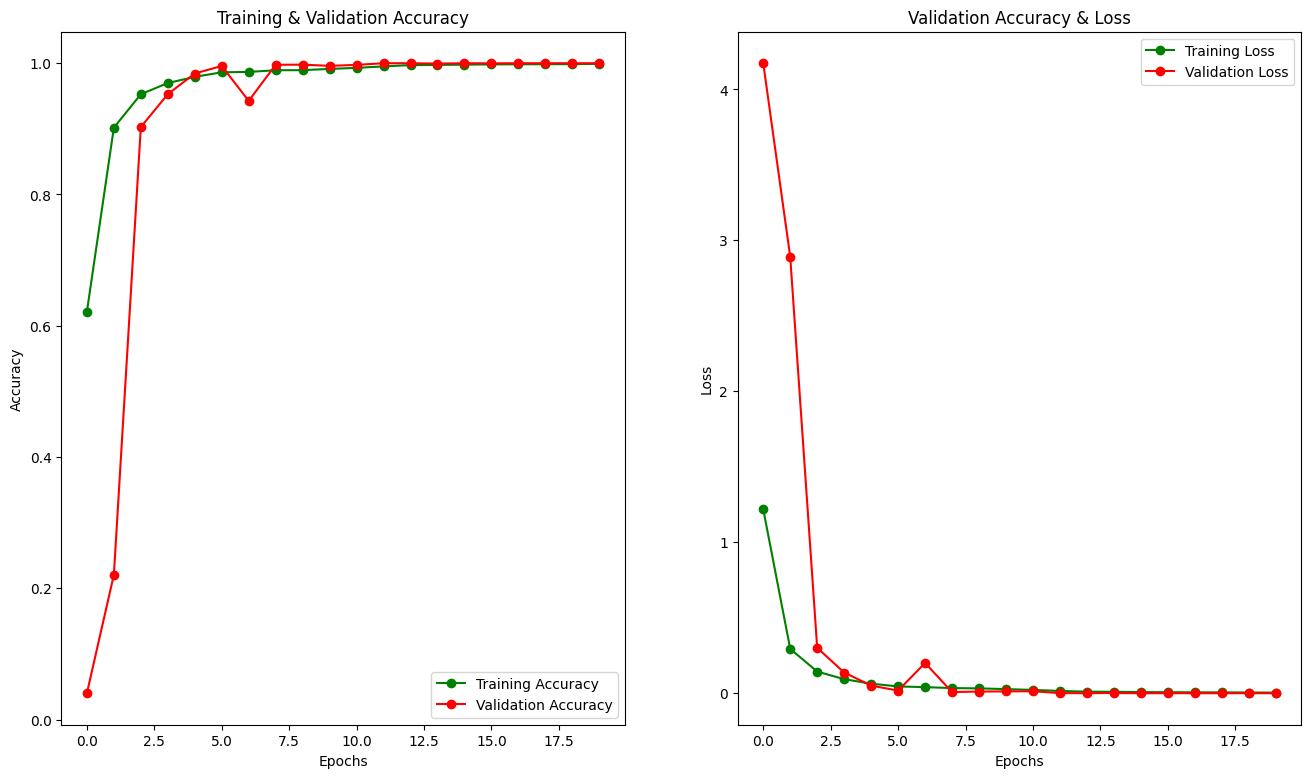

In [16]:
# Plot the accuracy and loss curves
epochs = [i for i in range(20)]  # 20 epochs de base mais 6 pour le basic suffit
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Validation Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [26]:
# Metrics of prediction 
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis = 1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]  

classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

cm = confusion_matrix(y,predictions)
cm = pd.DataFrame(cm)

cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
cm

225/225 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00  

,0,1,2,3,4,5,6,7,8,10,...,15,16,17,18,19,20,21,22,23,24
0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,498.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,0.0,247.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,0.0,0.0,348.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,436.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
